In [1]:
using ramnet
using ramnet.Utils: stack, ambiguity
using Images
using MLDatasets
using BenchmarkTools

┌ Info: Precompiling MLDatasets [eb30cadb-4394-5ae3-aed4-317e484a6458]
└ @ Base loading.jl:1278


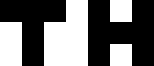

In [2]:
T = Bool[0 0 0; 1 0 1; 1 0 1]
H = Bool[0 1 0; 0 0 0; 0 1 0]

mosaicview(Gray.(T), Gray.(H); nrow=1, npad=1, fillvalue=1)

In [3]:
X, y = stack(vec(T), vec(H)), ["T", "H"]

model = MultiDiscriminatorClassifier{String}(9, 3; seed=1)

train!(model, X, y)

In [4]:
predict(model, X)

2-element Array{String,1}:
 "T"
 "H"

Testing with novel data:

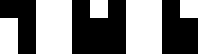

In [5]:
kinda_T = Bool[0 0 1; 1 0 1; 1 0 1]
kinda_H = Bool[0 1 0; 0 0 0; 0 0 0]
kinda_nothing = Bool[1 0 1; 1 0 0; 1 0 0]

mosaicview(Gray.(kinda_T), Gray.(kinda_H), Gray.(kinda_nothing); nrow=1, npad=1, fillvalue=1)

In [6]:
X_test = stack(map(vec, [kinda_T, kinda_H, kinda_nothing])...)

predict(model, X_test)

3-element Array{String,1}:
 "T"
 "H"
 "T"

MNIST:

In [8]:
X_train = permutedims(reshape(MNIST.traintensor(), 784, :)) .> 0.5
y_train = MNIST.trainlabels()

X_test = permutedims(reshape(MNIST.testtensor(), 784, :)) .> 0.5
y_test = MNIST.testlabels()

model_digits = MultiDiscriminatorClassifier{Int64}(784, 28; seed=1)

time_train!(model, X, y) = @btime train!($model, $X, $y)

time_train!(model_digits, X_train, y_train)

  1.460 s (6840000 allocations: 448.61 MiB)


In [9]:
function accuracy(y_pred, y_target)
    sum(y_pred .== y_target)/length(y_pred)
end

time_accuracy(y_pred, y_target) = @btime accuracy($y_pred, $y_target)

time_accuracy (generic function with 1 method)

In [10]:
time_accuracy(predict(model_digits, X_test), y_test)

  5.045 μs (3 allocations: 5.55 KiB)


0.8104

This result is similar to what I get with `wisardpkg` with bleaching **deactivated** but worst then the accuracy when it's activated. Bleaching could be understood as a disambiguation technique, for when there is a tie between discriminators' responses during classification. Before making use of bleaching, it would be interesting to measure the frequency of draws in the classfication of this test set:

In [13]:
ambiguity((values ∘ predict_response)(model_digits, X_test)...)

0.172

More then **17%** of the test images are tying and we should assume that a good number of them are being misclassified.